### Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import requests
import time
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import os

### Data Loading 

In [2]:
#Load Maintenance Dataset into df
df = pd.read_csv("Data/predictive_maintenance.csv")

### Data Preprocessing 

Before building any models for predictions, the data needs to be cleaned and prepared for prediction.

First thing is to normalize all features (metrics). This means to scale them down between 0 and 1, for this step I use Sklearn MinMaxScaler.

In [3]:
#Iterate over all columns in dataframe
for column in df:
    #Check if column contains "metric" inside of it
    if "metric" in column:
        #Start MinMaxScaler
        scaler = MinMaxScaler()
        
        #Fit Scaler on column
        scaler.fit(df[column].values.reshape(-1,1))
        
        #Replace column data with transformed data
        df[column] = scaler.transform(df[column].values.reshape(-1,1))

In [4]:
#Filter features to those with 'metric' in the column name
features = df[[i for i in df.columns if "metric" in i ]]

#Exctract failure column as target
target = df["failure"]

In [63]:
features.head(10)


,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9
0,0.198522,0.997045,0.0,0.504802,0.072165,0.056967,0.067308,0.000053
1,0.753950,0.008127,0.0,0.002401,0.082474,0.562811,0.038462,0.000160
2,0.558815,0.997168,0.0,0.243697,0.298969,0.326187,0.009615,0.000000
3,0.771078,0.031400,0.0,0.000000,0.051546,0.057080,0.038462,0.000053
4,0.903010,0.000000,0.0,0.000000,0.134021,0.471763,0.000000,0.000000
5,0.634875,0.020195,0.0,0.010804,0.092784,0.445457,0.000000,0.000000
6,0.222381,0.996429,0.0,0.096038,0.103093,0.278851,0.000000,0.000107
7,0.264190,0.000000,0.0,0.000600,0.185567,0.746791,0.019231,0.000160
8,0.653867,0.000000,0.0,0.005402,0.061856,0.335670,0.019231,0.000000
9,0.976077,0.018224,0.0,0.000000,0.134021,0.389832,0.009615,0.000000


Calculate and display correlations among the features.

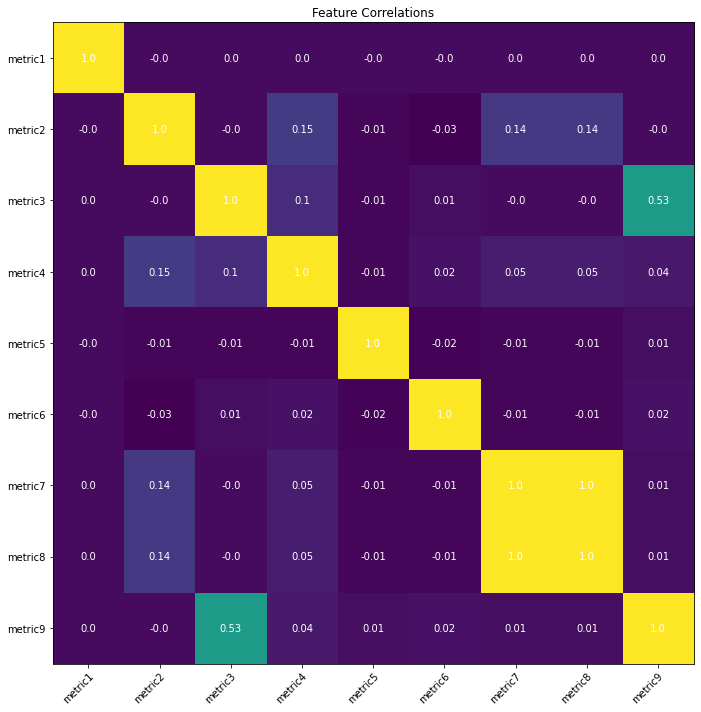

In [6]:
#Calculate pearson correlation for all features
correaltions = features.corr().round(2).values

#Create Fiure
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(correaltions)

#Set figure Size
ax.set_xticks(np.arange(features.shape[1]))
ax.set_yticks(np.arange(features.shape[1]))

#label With Features
ax.set_xticklabels(features.columns)
ax.set_yticklabels(features.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(features.shape[1]):
    for j in range(features.shape[1]):
        text = ax.text(j, i, correaltions[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Feature Correlations")
fig.tight_layout()
plt.show()

What we see is that metric7 and metric8 have perfect correlation, meaning they provide essentially the same information when it comes to prediction, therefore one will be removed from the feature set. We also see that metric3 and metric9 have 0.5 correlation, which is substantially higher than the rest. The remaining features are all uncorrelated with each other, which is good as they could be useful features to predict with.

In [7]:
#Drop metric7 due to perfect correlation with metric8
features = features.drop("metric7", axis = 1)

Next I will split the data using sklearn's train_test_split which will provide us with a test and a train dataset for both the targets and features.

In [8]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)

**Dealing with imbalanced data**

In [9]:
y_train.value_counts()

0    93281
1       89
Name: failure, dtype: int64

From what we see, the dataset has severely imbalanced data among the failure and non-failure classes, with a 1:1000 ratio between the two classes respectively. Due to this, I combine  **oversampling** and **undersampling** to balance the data. This is done by randomly duplicating failure data points and removing non-failure datapoints.

To do this, I set a datapoint expected size of that of the optimum sample size, after testing for the optimum size of each class type below, and I will undersample the negative data and oversample the positive data until I arrive at that optimum sample size. First I need to figure out what the optimal number of datapoints is:

In [10]:
#Set number of expected datapoints
EXPECTED_DATAPOINT_LIST = [100000, 75000, 50000, 25000, 20000, 15000, 12500, 10000, 8500, 7500, 5000, 2500, 1000, 500, 200]
auc_values = []
for expected_datapoints in EXPECTED_DATAPOINT_LIST:
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(features, target)
    start = time.time()
    #Undersample Non-Failure Data
    non_failure_indicies = np.where(y_train == 0)[0]

    #Sample non failure indicies
    non_failure_indicies = np.random.choice(non_failure_indicies, expected_datapoints)

    #Collect all failure data
    failure_indicies = np.where(y_train == 1)[0]

    #Filter data to limited non failure and all failure data
    x_train = x_train.iloc[np.append(non_failure_indicies, failure_indicies)]
    y_train = y_train.iloc[np.append(non_failure_indicies, failure_indicies)]

    #Oversample Failure Data using SMOTE
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)
    
    model = RandomForestClassifier().fit(x_train, y_train)
    probabilites = model.predict_proba(x_test)[:, 1]
    
    auc_values.append(round(roc_auc_score(y_test, probabilites), 2))

Text(0, 0.5, 'AUC')

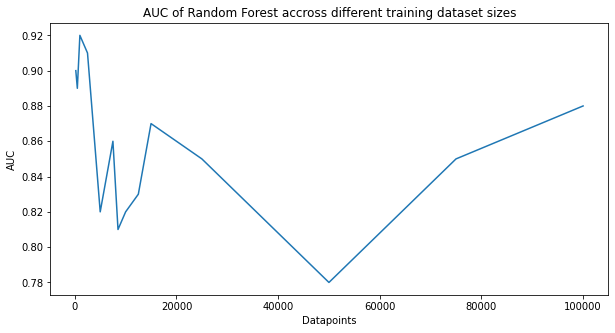

In [11]:
fig = plt.figure(figsize=(10,5))
plt.plot(EXPECTED_DATAPOINT_LIST, auc_values)
plt.title('AUC of Random Forest accross different training dataset sizes')
plt.xlabel('Datapoints')
plt.ylabel('AUC')

In [12]:
pd.Series(auc_values, index = EXPECTED_DATAPOINT_LIST)

100000    0.88
75000     0.85
50000     0.78
25000     0.85
20000     0.86
15000     0.87
12500     0.83
10000     0.82
8500      0.81
7500      0.86
5000      0.82
2500      0.91
1000      0.92
500       0.89
200       0.90
dtype: float64

We Find the best number of datapoints for auc is 200-1000, 1000 is used for more data

In [13]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [14]:
#Set number of expected datapoints
EXPECTED_DATAPOINTS = 1000

#Undersample Non-Failure Data
non_failure_indicies = np.where(y_train == 0)[0]

#Sample non failure indicies
non_failure_indicies = np.random.choice(non_failure_indicies, EXPECTED_DATAPOINTS)

#Collect all failure data
failure_indicies = np.where(y_train == 1)[0]

#Filter data to limited non failure and all failure data
x_train = x_train.iloc[np.append(non_failure_indicies, failure_indicies)]
y_train = y_train.iloc[np.append(non_failure_indicies, failure_indicies)]

#Oversample Failure Data using SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [15]:
y_train.value_counts()

0    1000
1    1000
Name: failure, dtype: int64

Now that the dataset is balanced, we move next to model selection.

### Model Selection 

I will consider using the following classifiers for the classification task:
- Logistic Regression
- Random Forest
- Decision Tree
- XGBoost
- Weighted Decision Tree
- Weighted Random Forest
- Linear SVM

In order to evaluate the different classifiers, we need to choose a scoring metric from below:

**Accuracy**  
This metric tells us how many of the correct classes our model predicts. The problem with this metric is that it is not representative of how good our model is doing in this situation, due to the imbalanced nature of the data. For example, if the model predicts only 0's, it will arrive at a very high accuracy. In this case, we look towards relevance, a metric like precision and recall.

**Precision**  
Precision is a metric with a formula of True Positive / (True Positive + False Positive). This is a score of when our model does predict a class, how accurate that prediction is. Meaning if we have numerous positive predictions, but a low precision score, it is predicting many negatives as positives, whereas if the precision is high and number of positive predictions is low, it accurately predicts what labels are positive. 

**Recall**  
Recall is a metric with a formula of True Positive / (True Positive + False Negative). This means that a model with a high recall value is very accurate when it predicts a positive (failure), and does not often incorrectly predict a positive to be a negative. 

**F1-Score**
This is a harmonic balance between Precision and Recall, and is given by the following formula:
                    F1-Score = 2 X (Precision x Recall)/(Precision + Recall)                

**Area Under Curve**
- AUC is a metric that combines both precision and recall.

Since our business case asks for minimizing both false negatives as well as false positives, I will be testing both F1-score and AUC to use either one of them as the model evaluation metric.  

In [16]:
models = {"Logistic Regression": LogisticRegression, 
          "Random Forest":RandomForestClassifier, 
          "Weighted Random Forest": RandomForestClassifier,
          "Decsion Tree":DecisionTreeClassifier, 
          "Weighted Decision Tree": DecisionTreeClassifier,
          "Linear SVM":SVC,
          "XGBoost": XGBClassifier}

In [17]:
colors = ["orange", "green", "brown", "purple", "pink","red", "cyan"]

[15:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


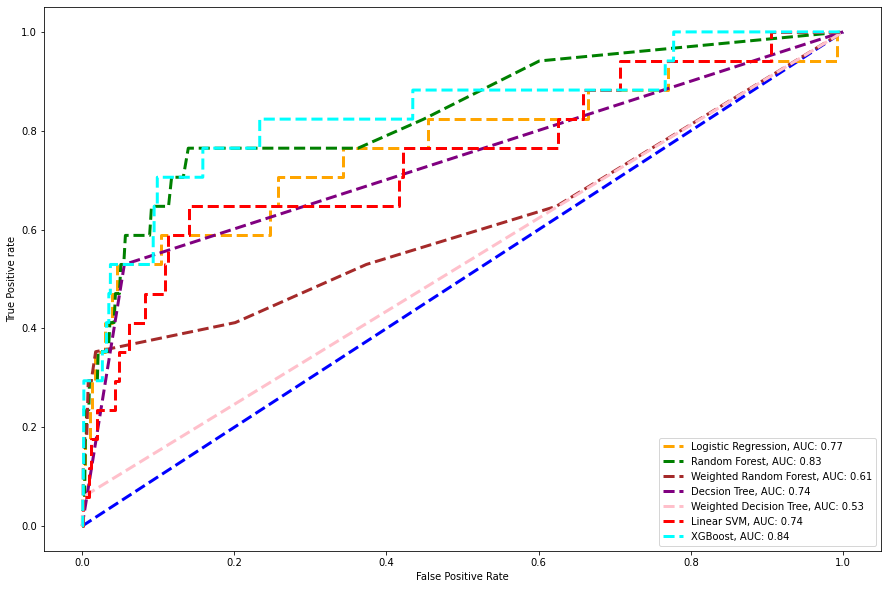

In [18]:
metrics = {}
#Prepare Figure
fig = plt.figure(figsize=(15,10))

#Plot Base 0,1 line
plt.plot([0,1], [0,1], linestyle='--', color='blue', linewidth=3)

for index, (model_name, model) in enumerate(models.items()):
    if model_name == "Linear SVM":
        loaded = model(probability=True).fit(x_train, y_train)
    elif model_name == "XGBoost":
        loaded = model(use_label_encoder=False).fit(x_train, y_train)
        
    #Check for weighted models
    elif model_name == "Weighted Decision Tree" or model_name == "Weighted Random Forest":
        #Split data
        x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(features, target, random_state=42)
        
        weights = {0: y_tree_train.value_counts()[0] / x_tree_train.shape[0], 1: y_tree_train.value_counts()[1] / x_tree_train.shape[0]}
        loaded = model(class_weight=weights).fit(x_tree_train, y_tree_train)
    else:
        loaded = model().fit(x_train, y_train)
    
    #Calculate Probabilities for failures
    probabilites = loaded.predict_proba(x_test)[:, 1]
    roc_data = roc_curve(y_test, probabilites)
    
    #Calculate AUC
    auc = round(roc_auc_score(y_test, probabilites), 2)
    plt.plot(roc_data[0], roc_data[1], label=f"{model_name}, AUC: {auc}",  linestyle='--', color=colors[index], linewidth=3)
    
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')

From what we can see, Random Forests performance is mostly the best, although sometimes ties with XGBoost. Therefore it is used as the model for prediction, an added benefit of using Random Forest is that we get a better understanding of the features used and their importance.

### Grid Search to find best hyperparameters

To determine the best combination of hyper-parameters, we use the test configurations of the following forest parameters:

- bootstrap
- max_depth
- max_features
- min_samples_leaf
- min_samples_split
- n_estimators

The scoring for this gridsearch is set to the roc_auc.

In [19]:
#Create random grid for CV to follow
random_grid = {'bootstrap': [True, False],
             'max_depth': [10, 50, 100, None],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 800, 1200, 1400, 1600, 2000]}

In [20]:
#Create GridSearch
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                           param_distributions = random_grid,
                           scoring = "roc_auc",
                           verbose=10,
                           cv=10,
                           n_jobs = -1,)
#Fit the gridsearch on the training data
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 800, 1200, 1400,
                                                         1600, 2000]},
                   scoring='roc_auc', verbose=10)

Below is the best parameters for this gridsearch:

In [21]:
grid_search.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

### Feature Importance

Now that we have the best parameters, let's see the features that are used in prediction and their importance (impact on prediction).

In [22]:
#Build forest with best parameters from grid search
forest = RandomForestClassifier(bootstrap= False,
                             max_depth= 50,
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             n_estimators= 200)

#Train model on data
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=200)

In [23]:
#Collect feature importance
importances = forest.feature_importances_

#Store in pandas series
importances = pd.Series(importances, index=features.columns)

#Sort importances
importances = importances.sort_values(ascending=False)

Text(0, 0.5, 'Metrics')

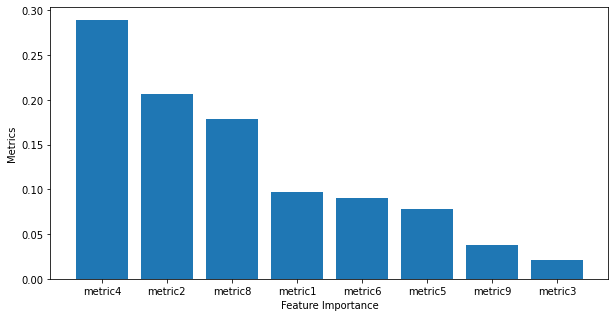

In [24]:
fig = plt.figure(figsize=(10,5))
plt.bar(importances.index, importances)

# x label
plt.xlabel('Feature Importance')
# y label
plt.ylabel('Metrics')

### Ensemble 

The next step is to build an ensemble of the Random Forests. This is due to the undersampling we have done before. In order for our models to use more non failure data, and to avoid overfitting with failure data via oversampling, I keep the same amount of datapoints but build an ensemble of 10 random forests, each with the optimal parameters found before.

Once these trees are built, we use a hard-voting system to determine the class, meaning we run the same prediction across all of the models, and take the majority vote as to what the predicted class is.

In [25]:
#function to train and return a trained model
def train_model(x_train, y_train):
    forest = RandomForestClassifier(bootstrap= False,
                             max_depth= 50,
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             n_estimators= 200)
    
    #Train model on data
    forest.fit(x_train, y_train)
    
    return forest

In [26]:
#function to create an ensemble
def build_ensemble(x_train, y_train):
    #Create list to store models
    ENSEMBLE_MODELS = 10
    ensemble = []
    #Iterate over number of models in ensemble
    for _ in range(ENSEMBLE_MODELS):
        #Use same code for preparing data#Set number of expected datapoints

        #Undersample Non-Failure Data
        non_failure_indicies = np.where(y_train == 0)[0]

        #Sample non failure indicies
        non_failure_indicies = np.random.choice(non_failure_indicies, EXPECTED_DATAPOINTS)

        #Collect all failure data
        failure_indicies = np.where(y_train == 1)[0]

        #Filter data to limited non failure and all failure data
        x_train_ensemble = x_train.iloc[np.append(non_failure_indicies, failure_indicies)]
        y_train_ensemble = y_train.iloc[np.append(non_failure_indicies, failure_indicies)]

        #Oversample Failure Data using SMOTE
        oversample = SMOTE()
        x_train_ensemble, y_train_ensemble = oversample.fit_resample(x_train_ensemble, y_train_ensemble)
        
        #train model using previous data
        forest = train_model(x_train_ensemble, y_train_ensemble)

        #Store model in ensemble
        ensemble.append(forest)
    
    return ensemble

In [27]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)

#Build Ensemble
ensemble = build_ensemble(x_train, y_train)

Below is a sample of ensemble prediction:

In [28]:
for i in range(x_test.shape[0]):
    
    #set sample datapoint
    datapoint = x_test.iloc[i].values

    predictions = []

    #Go over all models in our ensemble
    for model in ensemble:
        #Get Prediction
        prediction = model.predict([datapoint])[0]

        #Store prediction
        predictions.append(prediction)
    if pd.unique(predictions).shape[0] > 1:
        break

Below we see the predictions from all models:

In [29]:
predictions

[1, 0, 0, 0, 1, 0, 0, 1, 0, 0]

In [30]:
#Get Max Prediction and probability of failure
prediction = np.argmax(np.bincount(predictions))
Prediction_probability = sum(predictions)/10

Predicted value and failure probability:

In [31]:
print("Predicted Class :  "+ str(prediction))
print("Probability of failure :  " + str(Prediction_probability))


Predicted Class :  0
Probability of failure :  0.3


### Ensemble Metrics 

Below we see the results of the ensemble

**Validation**

For validation, we use RepeatedStratifiedKFold validation using AUC as our metric

In [33]:
ENSEMBLE_MODELS = 10

#Split data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)

validation_scores = []
validation_roc_curves = []

#Prepare Repeated StratifiedKFold with 10 splits each with 10 repeats
rskf = RepeatedStratifiedKFold(n_splits=10,n_repeats=10,)

#Prepare False Postitive Rate as a linespace between 0 and 1
val_false_positive_rates = np.linspace(0, 1, 100)
for train_index, validation_index in rskf.split(x_train, y_train):
    #Create list to store models
    ensemble = []
    
    #Take out Validation Set
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[validation_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[validation_index]
    
    
    #Build Ensemble
    ensemble = build_ensemble(x_train_fold, y_train_fold)
    
    #Predict validation values
    ensemble_probabilites = []

    for model_index, model in enumerate(ensemble):
        #Get Prediction
        probabilites = model.predict_proba(x_val_fold)[:, 1]

        ensemble_probabilites.append(probabilites)
    
    #Conver probabilities to array
    ensemble_probabilites = np.array(ensemble_probabilites)
    
    #Calculate AUC score for validation spplit
    val_roc_score = roc_auc_score(y_val_fold, ensemble_probabilites.mean(axis=0))
    
    #Get ROC curve for validation split
    roc_data = roc_curve(y_val_fold, ensemble_probabilites.mean(axis=0))
    
    #Save into respective lists
    validation_roc_curves.append(np.interp(val_false_positive_rates, roc_data[0], roc_data[1]))
    validation_scores.append(val_roc_score)

#Convert to true positive rates
val_true_positive_rates = np.array(validation_roc_curves).mean(axis=0)

**Test**

In [34]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)

#Build Ensemble
ensemble = build_ensemble(x_train, y_train)

In [35]:
#Predict Test values
ensemble_predictions = []

for model_index, model in enumerate(ensemble):
    #Get Prediction
    predictions = model.predict_proba(x_test)[:, 1]

    ensemble_predictions.append(predictions)
ensemble_predictions = np.array(ensemble_predictions)

In [36]:
test_roc_score = roc_auc_score(y_test, ensemble_predictions.mean(axis=0))

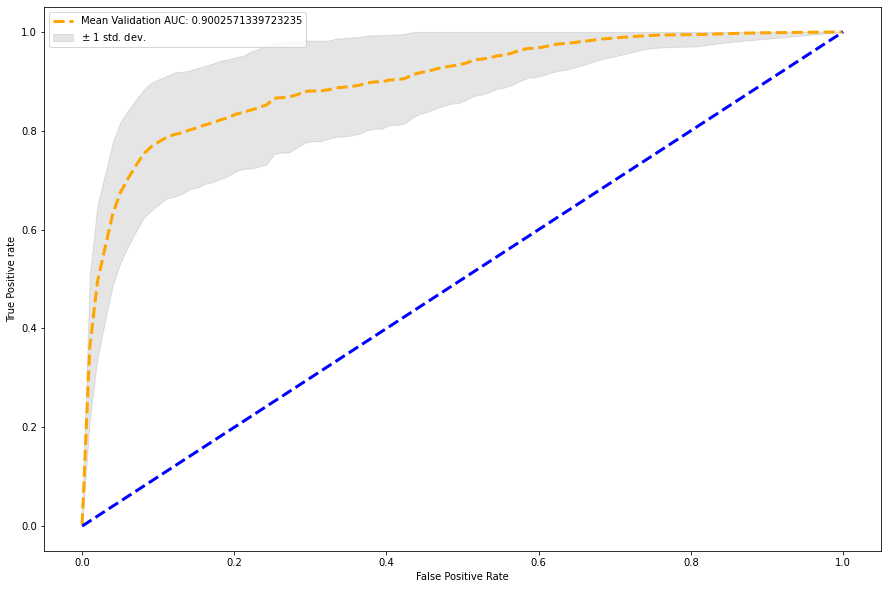

In [37]:
fig = plt.figure(figsize=(15,10))
plt.plot(val_false_positive_rates, val_true_positive_rates, label=f"Mean Validation AUC: {np.mean(validation_scores)}",  linestyle='--', color="Orange", linewidth=3)
#Get Upper and Lower STD for validation std
std = np.std(np.array(validation_roc_curves), axis=0)
tprs_upper = np.minimum(val_true_positive_rates + std, 1)
tprs_lower = np.maximum(val_true_positive_rates - std, 0)
plt.fill_between(val_false_positive_rates, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

#Plot Base 0,1 line
plt.plot([0,1], [0,1], linestyle='--', color='blue', linewidth=3)

# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')

(0.0, 1.0)

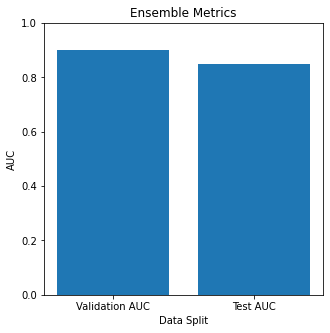

In [38]:
fig = plt.figure(figsize=(5,5))
plt.bar(["Validation AUC", "Test AUC"], [np.mean(validation_scores), test_roc_score])

plt.title('Ensemble Metrics')
# x label
plt.xlabel('Data Split')
# y label
plt.ylabel('AUC')
plt.ylim(0,1)

### Model Saving 

In [39]:
MODEL_DIR = "Saved Models/"

#Iterate over all of the models in ensemble
for index, model in enumerate(ensemble):
    
    #Get Model Name
    model_name = f"{MODEL_DIR}forest_model_{index+1}.sav"
    
    #Save model
    joblib.dump(model, model_name)

### Model Hosting 

For hosting our model, and building an API through it, we use popular hosting library flask.

We set up our service in server.py, we follow conventional flask documentation outlined in:

https://flask.palletsprojects.com/en/1.1.x/quickstart/

Our Project structure will look like this:

-> project dir/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->analytics.py  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->utils.py  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->server.py    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->uwsgi.ini  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> Saved Models/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_1.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_2.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_3.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_4.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_5.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_6.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_7.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_8.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_9.sav  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> forest_model_10.sav

**utils.py**

utils.py holds functionality that is not analysis or server related, therefore it has miscellaneous data/model loading functions:

In [40]:
#Loading Models
def load_ensemble(model_dir):
    ensemble = []
    for model_file in os.listdir(model_dir):
        model = joblib.load(f"{model_dir}{model_file}")
        ensemble.append(model)

    return ensemble

load_models takes the ensemble saved files as input and loads the models, storing them into a list

In [41]:
#Saves trained model
def save_model(model, model_dir, model_name):
    joblib.dump(model, model_dir + model_name)

save_model saves a single model

In [42]:
#Loading Data
def load_data(data_dir):
    data_extension = data_dir.split(".")[-1]
    #Check extension type
    if data_extension == "csv":
        df = pd.read_csv(data_dir)
    elif data_extension == "tsv":
        df = pd.read_csv(data_dir, sep="\t")
    else:
        df = pd.read_excel(data_dir)

    return df

load_data loads the excel/csv/tsv file and returns a pandas dataframe

In [43]:
#Normalizing data
def normalize_data(df):
    for column in df:
        # Start MinMaxScaler
        scaler = MinMaxScaler()

        # Fit Scaler on column
        scaler.fit(df[column].values.reshape(-1, 1))

        # Replace column data with transformed data
        df[column] = scaler.transform(df[column].values.reshape(-1, 1))

    return df

normalize_data applies a min max scaler to each of the feature columns in the provided dataframe

In [44]:
#Preprocessing data
def preproccess_data(df, target_col, feature_col_filter):
    #Get Target column
    target = df[target_col]

    #Get feature columns
    features = df[[i for i in df.columns if feature_col_filter in i]]
    #Normalize Features
    features = normalize_data(features)

    #Imbalanced data
    # Undersample Non-Failure Data
    non_failure_indicies = np.where(target == 0)[0]

    # Sample non failure indicies
    non_failure_indicies = np.random.choice(non_failure_indicies, EXPECTED_DATAPOINTS)

    # Collect all failure data
    failure_indicies = np.where(target == 1)[0]

    # Filter data to limited non failure and all failure data
    features = features.iloc[np.append(non_failure_indicies, failure_indicies)]
    target = target.iloc[np.append(non_failure_indicies, failure_indicies)]

    # Oversample Failure Data using SMOTE
    oversample = SMOTE()
    features, target = oversample.fit_resample(features, target)

    return features, target

preproccess_data applies all balancing techniques used before.

**analytics.py**

analytics.py holds all analysis related functionality, this encompasses model predicting, data exploration and basic analysis. 

In [45]:
#Function to make prediction with ensemble
def ensebmle_predict(ensemble, features):
    predictions = []

    # Go over all models in our ensemble
    for model in ensemble:
        # Get Prediction
        prediction = model.predict([features])[0]

        # Store prediction
        predictions.append(prediction)

    # Get Max Prediction
    prediction = np.argmax(np.bincount(predictions))
    return prediction

ensemble_predict takes in the stored models in the ensemble and makes a prediction.

In [46]:
#Function to train new model on provided data
def train_model(features, target):
    forest = RandomForestClassifier(bootstrap=False,
                                    max_depth=20,
                                    max_features='auto',
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    n_estimators=600)

    forest.fit(features, target)

    return forest

train_model builds one random forest with the provided features and target datapoints.

In [47]:
#Loads data,
def train_ensemble(data_file, model_dir, number_of_models=10):

    #Iterating over number of models in ensemble
    for index in range(number_of_models):
        #laod data into df
        df = load_data(data_file)

        #prerpocess data
        features, target = preproccess_data(df, TARGET_COLUMN, FEATURE_FILTER)

        model = train_model(features, target)

        save_model(model, model_dir, f"forest_model_{index+1}.sav")


train_ensemble is the root function that builds and trains all models in the ensemble, it calls the following functions
- load_data()
- preprocess_data()
- train_model()
- save_model()

**server.py**

Imports and app startup:

In [76]:
from flask import Flask, request, jsonify
from utils import load_ensemble
from analytics import ensebmle_predict, TARGET_COLUMN, FEATURE_FILTER
import json

app = Flask(__name__)

Our server uses load_ensemble function from utils to load in the saved models.

In [88]:
#Load Ensemble
enseble = load_ensemble(MODEL_DIR)

In order to call our service, we need to use the python requests library, and embed our features in a dictionary, then jsonify that dictionary for the request to understand it. 

Now that our server is prepared, and we can pass data through it. We use the ensemble_predict function from analytics.py and return the output as a json response.

To ensure our server can run at any time, we create a wsgi configuration. This is done in a file called uswgi.ini. this routes our application configuration in the correct way. The following is the configuration that is set up:

### Docker Building 

For best practice, our service is then dockerized, this means that the tool is put into a package that contains all project files and dependencies so it can be easily run anywhere. It builds the project with all dependencies and requirements, making it run the same on any device or system. It builds this tool in a virtual environment.

In order to do this, two files are created, first our **requirements.txt**. This tells the environment exactly what library dependencies are being used:

- numpy == 1.19.5
- flask == 1.1.2
- joblib == 1.0.0
- scikit-learn == 0.24.1
- pandas == 1.2.0
- imbalanced-learn == 0.8.0

in requirements.txt

The second is the **Dockerfile**, this outlines the steps docker should follow when building our project.  

FROM python:3.8   
lets docker know which version of python it should install in this environment

COPY ./requirements.txt .  
creates a copy of our requirements.txt in the docker environment, allowing it to read the file

RUN pip install --upgrade pip  
RUN pip install -r requirements.txt  
These two lines install pip (Pip Installs Packages) and all the requirements listed in requirements.txt in the virtual environment

EXPOSE 80  

COPY . .  
CMP python3 server.py  
Finally we copy all files found in the directory to be able read from, and we run the command line command "python3 server.py" which will host our tool.

In order to run the docker container, we need to first **build** then **run** it.  

To build it, we follow the following command format:  
docker build -t [project name] [directory]  

which when translated becomes:  
docker build -t application_name .

Then to run the application, run the following command:

docker run -p 5000:5000 application_name (expose app to 5000, the flask run port)

### Server Connection 

The server is set up on an AWS EC2 t2.micro instance. The public ip address for the instance is **18.221.149.92**. So in order to connect to it we use the same request setup used for local.

In [78]:
#Code used to call api
response = requests.post("http://18.221.149.92:5000/", data=json.dumps(sample_data))

In [79]:
response

<Response [200]>

In [80]:
json.loads(response.content)

{'prediction': '0'}

### Below is a demonstration of the tool:

In [2]:
# This is a tool to test prediction

import pandas as pd
import requests
import json
from sklearn.preprocessing import MinMaxScaler

#Load Dataframe
df = pd.read_csv("Data/predictive_maintenance.csv")

# Iterate over all columns in dataframe
for column in df:
    # Check if column contains "metric" inside of it
    if "metric" in column:
        # Start MinMaxScaler
        scaler = MinMaxScaler()

        # Fit Scaler on column
        scaler.fit(df[column].values.reshape(-1, 1))

        # Replace column data with transformed data
        df[column] = scaler.transform(df[column].values.reshape(-1, 1))

#Filter features to those with metric in the name of column
features = df[[i for i in df.columns if "metric" in i ]]

#Exctract failure column as target
target = df["failure"]

#Drop metric7 due to perfect correlation with metric8
features = features.drop("metric7", axis = 1)

data_sample = features.iloc[0]
data_sample = {"features":list(data_sample)}

#Code used to call api
response = requests.post("http://18.221.149.92:5000/", data=json.dumps(data_sample))

print(f"Tool prediction is: {json.loads(response.content)['prediction']}, actual value is {target.iloc[0]}")

Tool prediction is: 1, actual value is 1
